In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /home/denys_herasymuk/UCU/4course_2term/Bachelor_Thesis/Code/fairness-variance


## Import dependencies

In [4]:
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
from IPython.display import display

from configs.models_config_for_tuning import MODELS_CONFIG
from source.custom_initializers import create_config_obj, create_models_config_from_tuned_params_df
from source.custom_classes.metrics_composer import MetricsComposer
from source.custom_classes.metrics_visualizer import MetricsVisualizer

sns.set_theme(style="whitegrid")

## Create average metrics files

In [5]:
config = create_config_obj(config_yaml_path=os.path.join('configs', 'experiment1_compas_config.yaml'))

TUNED_PARAMS_FILE_PATH = os.path.join('results', 'models_tuning', f'tuning_results_{config.dataset_name}_20230117__012024.csv')
models_tuned_params_df = pd.read_csv(TUNED_PARAMS_FILE_PATH)

experiment_models_config = create_models_config_from_tuned_params_df(
    models_config_for_tuning=MODELS_CONFIG,
    models_tuned_params_df=models_tuned_params_df,
)

In [6]:
METRICS_PATH = os.path.join('results', 'hypothesis_space', 'COMPAS_Without_Sensitive_Attributes_Metrics_20230123__233917')
# METRICS_PATH = os.path.join('results', 'hypothesis_space', 'COMPAS_Without_Sensitive_Attributes_Metrics_20230122__202033')
# MODELS_NAMES = [model_config['model_name'] for model_config in config.MODELS_CONFIG if 'MLPClassifier' not in model_config['model_name']]
MODELS_NAMES = list(experiment_models_config.keys())
MODELS_NAMES

['DecisionTreeClassifier',
 'LogisticRegression',
 'RandomForestClassifier',
 'XGBClassifier',
 'KNeighborsClassifier']

In [7]:
visualizer = MetricsVisualizer(METRICS_PATH, config.dataset_name, MODELS_NAMES, config.sensitive_attributes_dct)

In [8]:
visualizer.models_average_metrics_dct[MODELS_NAMES[0]].head(20)

,Metric,Model_Name,overall,sex_priv,sex_dis,race_priv,race_dis,sex&race_priv,sex&race_dis
0,Accuracy,DecisionTreeClassifier,0.672822,0.669587,0.673652,0.652840,0.685867,0.654562,0.686759
1,Entropy,DecisionTreeClassifier,0.051661,0.033032,0.049466,0.048003,0.025797,0.034797,0.025043
2,F1,DecisionTreeClassifier,0.638622,0.542035,0.655876,0.487250,0.702136,0.454159,0.716828
3,FNR,DecisionTreeClassifier,0.376405,0.471788,0.359456,0.556201,0.292513,0.575510,0.277502
4,FPR,DecisionTreeClassifier,0.283788,0.247434,0.293992,0.222237,0.336888,0.227241,0.355710
5,General_Ensemble_Accuracy,DecisionTreeClassifier,0.672822,0.669587,0.673652,0.652840,0.685867,0.654562,0.686759
6,IQR,DecisionTreeClassifier,0.078650,0.084148,0.077351,0.078529,0.078741,0.092095,0.078987
7,Jitter,DecisionTreeClassifier,0.109435,0.127310,0.105248,0.104866,0.112474,0.130555,0.110040
8,Label_Stability,DecisionTreeClassifier,0.860543,0.834369,0.866655,0.866140,0.856835,0.830447,0.860657
9,Mean,DecisionTreeClassifier,0.526985,0.568931,0.517168,0.592513,0.483998,0.603045,0.472880


## Visualize average metrics

In [43]:
# Example of MetricsComposer usage
metrics_composer = MetricsComposer(config.sensitive_attributes_dct,
                                   visualizer.models_average_metrics_dct['DecisionTreeClassifier'])
metrics_composer.compose_metrics()

,Metric,sex,race,sex&race
0,Equalized_Odds_TPR,0.112332,0.263687,0.298008
1,Equalized_Odds_FPR,0.046558,0.114651,0.128469
2,Disparate_Impact,1.001701,1.238751,1.163451
3,Statistical_Parity_Difference,0.001619,0.195733,0.142697
4,Accuracy_Parity,0.004065,0.033027,0.032197
5,Label_Stability_Ratio,1.038696,0.989257,1.036377
6,IQR_Parity,-0.006797,0.000212,-0.013108
7,Std_Parity,-0.009484,0.001810,-0.013611
8,Std_Ratio,0.876952,1.026496,0.836809
9,Jitter_Parity,-0.022062,0.007608,-0.020515


### Overall metrics visualizations

In [44]:
def overall_metric_comparison(prediction_metric_name, dataset_name, models_average_results_dct):
    comparison_df = pd.DataFrame(columns=('Dataset_Name', 'Metric_Name', 'Model_Name', 'Metric_Value'))
    for idx, model_name in enumerate(models_average_results_dct.keys()):
        model_average_results_df = models_average_results_dct[model_name]
        comparison_df.loc[idx] = [dataset_name, prediction_metric_name, model_name, model_average_results_df['overall'].loc[prediction_metric_name]]

    return comparison_df.sort_values(by=['Metric_Value'], ascending=False, axis=0)


def display_all_overall_metrics(dataset_name, model_names, models_average_results_dct):
    overall_metrics = list(models_average_results_dct[list(models_average_results_dct.keys())[0]].index)

    for overall_metric in overall_metrics:
        comparison_df = overall_metric_comparison(overall_metric, dataset_name, models_average_results_dct)
        print('#' * 30, f' {overall_metric} Comparison ', '#' * 30)
        display(comparison_df)

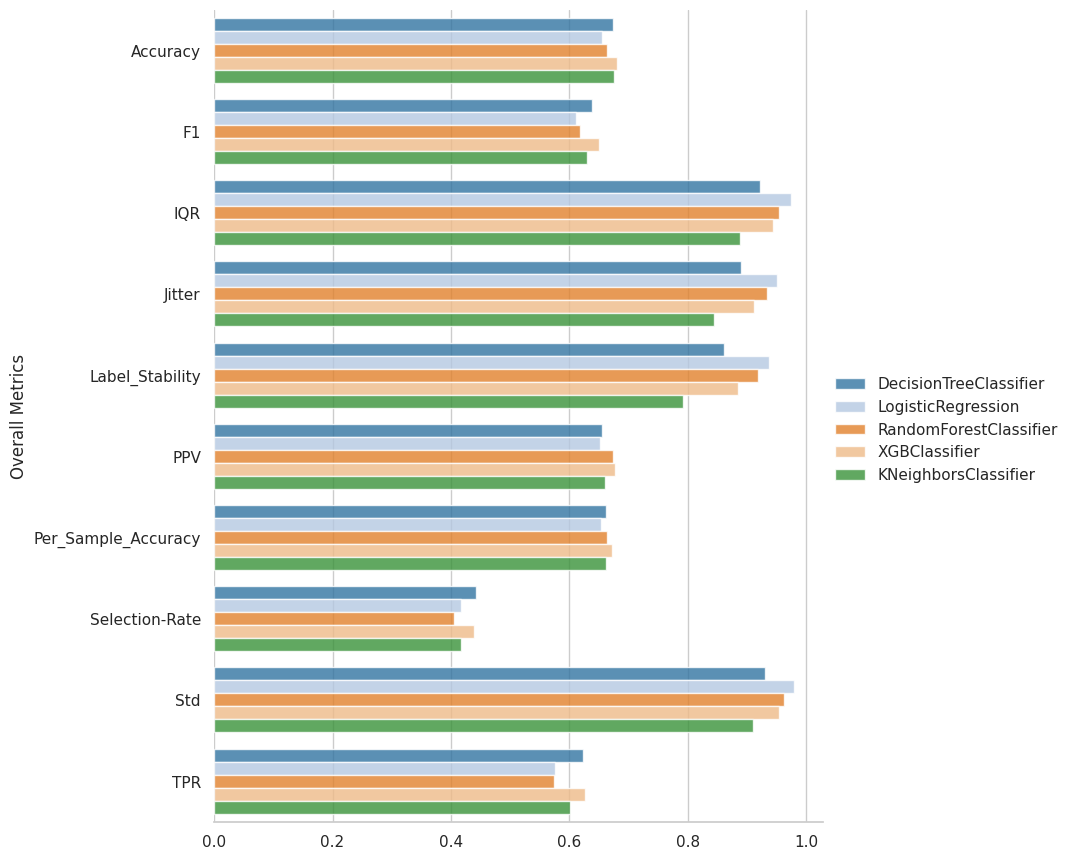

In [45]:
visualizer.visualize_overall_metrics(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate',
                   'Per_Sample_Accuracy', 'Label_Stability'],
    reversed_metrics_names=['Std', 'IQR', 'Jitter'],
    x_label="Overall Metrics"
)

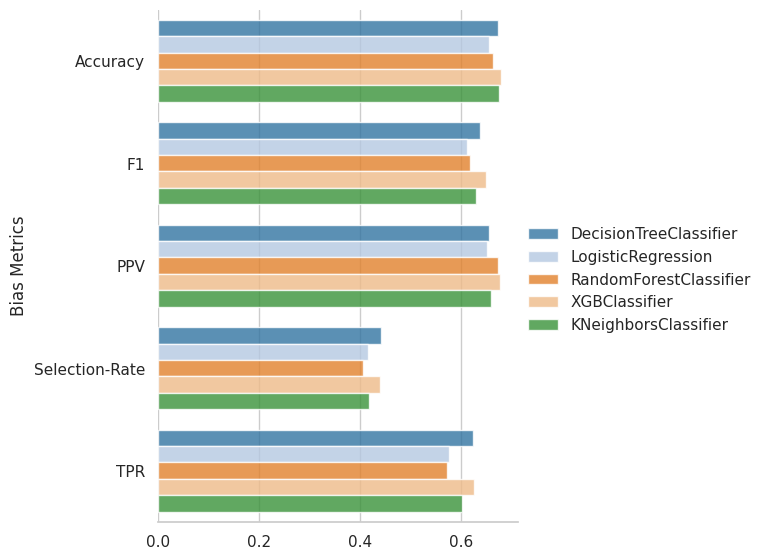

In [46]:
visualizer.visualize_overall_metrics(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate'],
    x_label="Bias Metrics"
)

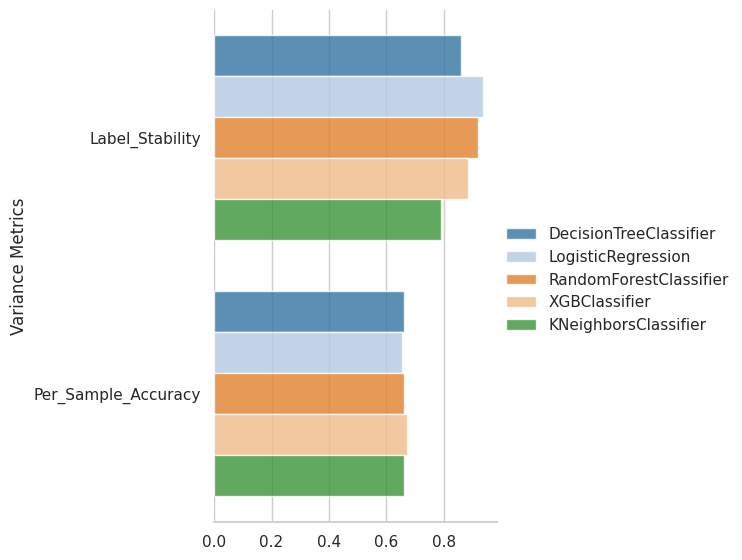

In [47]:
visualizer.visualize_overall_metrics(
    metrics_names=['Per_Sample_Accuracy', 'Label_Stability'],
    x_label="Variance Metrics"
)

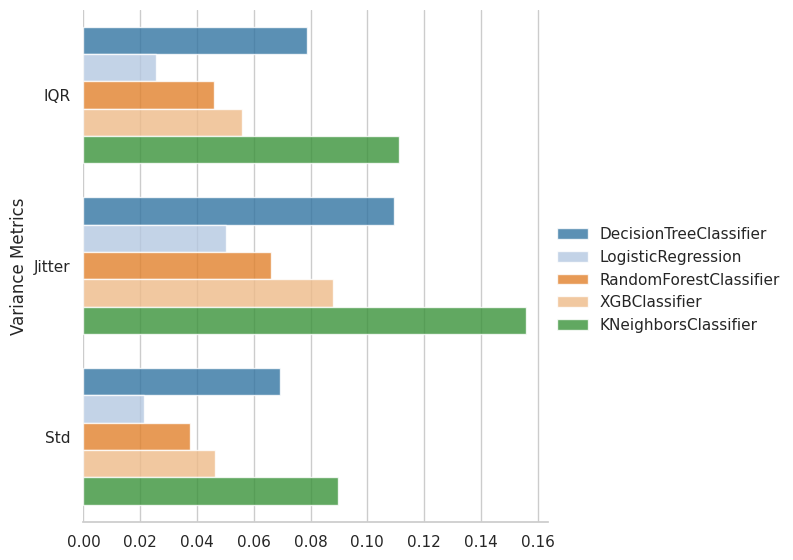

In [48]:
visualizer.visualize_overall_metrics(
    metrics_names=['Std', 'IQR', 'Jitter'],
    x_label="Variance Metrics"
)

In [49]:
visualizer.models_composed_metrics_df.head(20)

,Metric,sex,race,sex&race,Model_Name
0,Equalized_Odds_TPR,0.112332,0.263687,0.298008,DecisionTreeClassifier
1,Equalized_Odds_FPR,0.046558,0.114651,0.128469,DecisionTreeClassifier
2,Disparate_Impact,1.001701,1.238751,1.163451,DecisionTreeClassifier
3,Statistical_Parity_Difference,0.001619,0.195733,0.142697,DecisionTreeClassifier
4,Accuracy_Parity,0.004065,0.033027,0.032197,DecisionTreeClassifier
5,Label_Stability_Ratio,1.038696,0.989257,1.036377,DecisionTreeClassifier
6,IQR_Parity,-0.006797,0.000212,-0.013108,DecisionTreeClassifier
7,Std_Parity,-0.009484,0.001810,-0.013611,DecisionTreeClassifier
8,Std_Ratio,0.876952,1.026496,0.836809,DecisionTreeClassifier
9,Jitter_Parity,-0.022062,0.007608,-0.020515,DecisionTreeClassifier


In [50]:
bias_metrics_lst = [
    'Accuracy_Parity',
    'Equalized_Odds_TPR',
    'Equalized_Odds_FPR',
    'Disparate_Impact',
    'Statistical_Parity_Difference',
]
models_bias_metrics_chart, select_bias_metric_legend, bias_color_legend = \
                visualizer.create_models_metrics_bar_chart(bias_metrics_lst, metrics_group_name="Bias")

In [51]:
variance_metrics_lst = [
    'IQR_Parity',
    'Label_Stability_Ratio',
    'Std_Parity',
    'Std_Ratio',
    'Jitter_Parity',
]
models_variance_metrics_chart, select_variance_metric_legend, variance_color_legend = \
                visualizer.create_models_metrics_bar_chart(variance_metrics_lst, metrics_group_name="Variance")

In [52]:
(
    alt.hconcat(
        alt.vconcat(
            select_bias_metric_legend.properties(height=200, width=50),
            select_variance_metric_legend.properties(height=200, width=50),
            bias_color_legend.properties(height=200, width=50),
        ),
        models_bias_metrics_chart.properties(height=200, width=300, title="Bias Metric Plot"),
        models_variance_metrics_chart.properties(height=200, width=300, title="Variance Metric Plot"),
    )
)

alt.HConcatChart(...)

In [9]:
models_average_results_df = visualizer.all_models_metrics_df

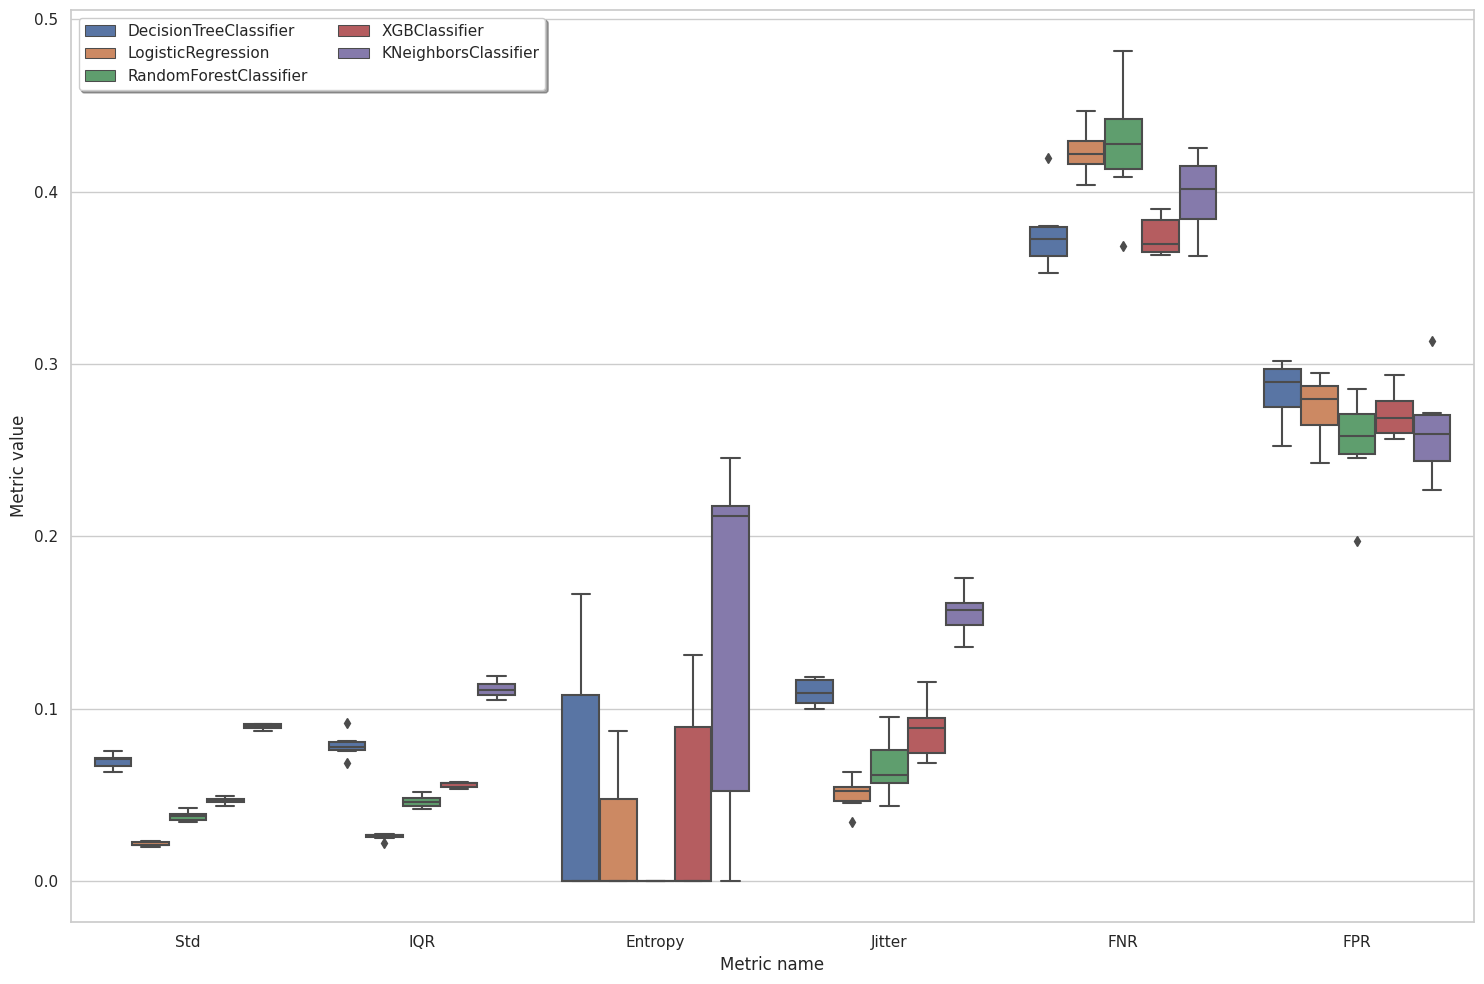

In [10]:
to_plot = models_average_results_df[models_average_results_df['Metric'].isin(['Std', 'IQR', 'Entropy', 'Jitter', 'FNR','FPR'])]

plt.figure(figsize=(15, 10))


sns.boxplot(x = to_plot['Metric'],
            y = to_plot['overall'],
            hue= to_plot['Model_Name'],
            #order=['Accuracy']
            #order=['Accuracy','TNR','TPR','FNR','FPR','Selection-Rate']
           )

plt.legend(loc='upper left',
          ncol=2, fancybox=True, shadow=True)
plt.xlabel("Metric name")
plt.ylabel("Metric value")
#plt.ylim(0,1)
#plt.title("Peformance on overall test set: "+experiment)

plt.tight_layout()

#plt.savefig(filename+'_overall.png', bbox_inches='tight')

In [11]:
sorted_models_composed_metrics_df = visualizer.melted_models_composed_metrics_df.sort_values(by=['Value'])

In [12]:
set(sorted_models_composed_metrics_df.Metric)

{'Accuracy_Parity',
 'Disparate_Impact',
 'Equalized_Odds_FPR',
 'Equalized_Odds_TPR',
 'IQR_Parity',
 'Jitter_Parity',
 'Label_Stability_Ratio',
 'Statistical_Parity_Difference',
 'Std_Parity',
 'Std_Ratio'}

In [18]:
def color_df(val):
    if val == 'RandomForestClassifier':
        color = 'pink' 
    if val == 'LogisticRegression':
        color = 'yellow'
    if val == 'DecisionTreeClassifier':
        color = 'cyan'
    if val == 'XGBClassifier':
        color = 'lightgreen'
    if val == 'KNeighborsClassifier':
        color = 'orange'
    if val == 'MLPClassifier':
        color = 'lightpurple'

    return 'background-color: %s' % color


In [14]:
results = {}

for metric in ['Disparate_Impact','Label_Stability_Ratio']:
    for subgroup in config.sensitive_attributes_dct.keys():
        key_name = metric + '_' + subgroup
        results[key_name] = sorted_models_composed_metrics_df[(sorted_models_composed_metrics_df.Metric == metric) & (sorted_models_composed_metrics_df.Subgroup == subgroup)]['Model_Name'].values
        
#pd.DataFrame(results).T
pd.DataFrame(results).T.style.applymap(color_df)

,0,1,2,3,4
Disparate_Impact_sex,DecisionTreeClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression,RandomForestClassifier
Disparate_Impact_race,DecisionTreeClassifier,KNeighborsClassifier,XGBClassifier,RandomForestClassifier,LogisticRegression
Disparate_Impact_sex&race,DecisionTreeClassifier,XGBClassifier,KNeighborsClassifier,RandomForestClassifier,LogisticRegression
Label_Stability_Ratio_sex,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,XGBClassifier
Label_Stability_Ratio_race,KNeighborsClassifier,RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,XGBClassifier
Label_Stability_Ratio_sex&race,KNeighborsClassifier,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,XGBClassifier


In [15]:
results = {}

for metric in ['Accuracy_Parity','Equalized_Odds_FPR','Statistical_Parity_Difference','IQR_Parity','Jitter_Parity','Std_Parity']:
    for subgroup in config.sensitive_attributes_dct.keys():
        key_name = metric + '_' + subgroup
        results[key_name] = sorted_models_composed_metrics_df[(sorted_models_composed_metrics_df.Metric == metric) & (sorted_models_composed_metrics_df.Subgroup == subgroup)]['Model_Name'].values

        
pd.DataFrame(results).T.style.applymap(color_df)

,0,1,2,3,4
Accuracy_Parity_sex,XGBClassifier,RandomForestClassifier,KNeighborsClassifier,DecisionTreeClassifier,LogisticRegression
Accuracy_Parity_race,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier,DecisionTreeClassifier
Accuracy_Parity_sex&race,RandomForestClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier
Equalized_Odds_FPR_sex,DecisionTreeClassifier,KNeighborsClassifier,LogisticRegression,XGBClassifier,RandomForestClassifier
Equalized_Odds_FPR_race,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression
Equalized_Odds_FPR_sex&race,DecisionTreeClassifier,KNeighborsClassifier,XGBClassifier,RandomForestClassifier,LogisticRegression
Statistical_Parity_Difference_sex,DecisionTreeClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression,RandomForestClassifier
Statistical_Parity_Difference_race,DecisionTreeClassifier,KNeighborsClassifier,XGBClassifier,RandomForestClassifier,LogisticRegression
Statistical_Parity_Difference_sex&race,DecisionTreeClassifier,XGBClassifier,KNeighborsClassifier,RandomForestClassifier,LogisticRegression
IQR_Parity_sex,DecisionTreeClassifier,XGBClassifier,KNeighborsClassifier,LogisticRegression,RandomForestClassifier


In [28]:
def plot_ranked_models_matrix(sorted_models_composed_metrics_df, metrics_lst, subgroups_lst, num_models):
    results = {}

    for metric in metrics_lst:
        for subgroup in subgroups_lst:
            key_name = metric + '_' + subgroup
            results[key_name] = dict()
            sorted_model_names_arr = sorted_models_composed_metrics_df[
                (sorted_models_composed_metrics_df.Metric == metric) & 
                (sorted_models_composed_metrics_df.Subgroup == subgroup)
            ]['Model_Name'].values
            for idx, model_name in enumerate(sorted_model_names_arr):
                rank = idx + 1
                results[key_name][model_name] = rank

    rank_colors = sns.color_palette("coolwarm", n_colors=num_models).as_hex()[::-1]
    
    return pd.DataFrame(results).T.style.applymap(lambda rank: 'background-color: %s' % rank_colors[rank - 1])

In [29]:
plot_ranked_models_matrix(
    sorted_models_composed_metrics_df,
    metrics_lst=['Accuracy_Parity', 'Equalized_Odds_FPR',
                 'Statistical_Parity_Difference', 'IQR_Parity',
                 'Jitter_Parity', 'Std_Parity'],
    subgroups_lst=config.sensitive_attributes_dct.keys(),
    num_models=len(MODELS_NAMES)
)

,XGBClassifier,RandomForestClassifier,KNeighborsClassifier,DecisionTreeClassifier,LogisticRegression
Accuracy_Parity_sex,1,2,3,4,5
Accuracy_Parity_race,4,3,2,5,1
Accuracy_Parity_sex&race,2,1,3,5,4
Equalized_Odds_FPR_sex,4,5,2,1,3
Equalized_Odds_FPR_race,3,2,4,1,5
Equalized_Odds_FPR_sex&race,3,4,2,1,5
Statistical_Parity_Difference_sex,2,5,3,1,4
Statistical_Parity_Difference_race,3,4,2,1,5
Statistical_Parity_Difference_sex&race,2,4,3,1,5
IQR_Parity_sex,2,5,3,1,4
